# <a id='toc1_'></a>[Exploring the Toulouse public library loans dataset](#toc0_)

**A comprehensive Exploratory Data Analysis (EDA) guide for tabular datasets: techniques, visualizations & best practices for data scientists**

![An aerial view of the Toulouse public Library](img/toulouse_library_dataset.jpg "Photographie de la médiathèque José Cabanis, Toulouse (source: Live Maps).")

## <a id='toc1_1_'></a>[Table of Content](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Exploring the Toulouse public library loans dataset](#toc1_)    
  - [Table of Content](#toc1_1_)    
  - [Section 1 — General dataset overview](#toc1_2_)    
    - [Load the dataset](#toc1_2_1_)    
    - [Basic shape and data types](#toc1_2_2_)    
    - [Ensure expected types and coerce where needed](#toc1_2_3_)    
    - [Missing values summary](#toc1_2_4_)    
    - [Duplicates](#toc1_2_5_)    
    - [Drop orphaned features](#toc1_2_6_)    
    - [Basic statistics about the loans](#toc1_2_7_)    
    - [Outliers detection](#toc1_2_8_)    
    - [Distribution concentration](#toc1_2_9_)    
  - [Section 2 — Column-by-column deep dives](#toc1_3_)    
    - [Years](#toc1_3_1_)    
    - [nb_loans](#toc1_3_2_)    
    - [Title](#toc1_3_3_)    
    - [Author](#toc1_3_4_)    
    - [media_type and media_subtype](#toc1_3_5_)    
    - [Audience](#toc1_3_6_)    
    - [Remaining columns (publisher, classification, library, spine_label)](#toc1_3_7_)    
  - [Section 3 — Summaries by category](#toc1_4_)    
    - [Plot years with most loan counts per audience](#toc1_4_1_)    
    - [Plot years with most loan counts per media_type](#toc1_4_2_)    
    - [Most popular authors — overall, per audience, per media_type (plots)](#toc1_4_3_)    
    - [Trends](#toc1_4_4_)    
  - [Section 4 — Jupyter interactive widget](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

from typing import List, Iterable, Optional, Tuple

In [2]:
# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid", rc={"figure.figsize": (10,5)})

## <a id='toc1_2_'></a>[Section 1 — General dataset overview](#toc0_)

### <a id='toc1_2_1_'></a>[Load the dataset](#toc0_)

In [3]:
df = pd.read_csv("toulouse_public_library_loans.csv", sep=";")
df.head()

,year,nb_loans,title,author,publisher,classification,library,spine_label,audience,media_subtype,media_type
0,2023.0,207,Top Gun : Maverick,"Kosinski, Joseph","Boulogne-Billancourt : Paramount Pictures, 2022",AV TOPG,CABANIS,AV TOPG,A,DVDFIC,films
1,2023.0,193,Trois mille ans à t'attendre,"Miller, George","Paris : Metropolitan filmexport, 2023",F TROI,CABANIS,F TROI,A,DVDFIC,films
2,2023.0,152,Compétition officielle,"Cohn, Mariano","Paris : Wild side video, 2022",COMP,CABANIS,COMP,A,DVDFIC,films
3,2023.0,151,Licorice pizza,"Anderson, Paul Thomas","Paris : Universal Pictures Vidéo, 2022",LICO,CABANIS,LICO,A,DVDFIC,films
4,2023.0,144,Le discours,"Tirard, Laurent","Paris : Le Pacte, 2021",C DISC,CABANIS,C DISC,A,DVDFIC,films


### <a id='toc1_2_2_'></a>[Basic shape and data types](#toc0_)

In [4]:
print("Shape:", df.shape)
df.dtypes

Shape: (21446, 11)


year              float64
nb_loans            int64
title              object
author             object
publisher          object
classification     object
library            object
spine_label        object
audience           object
media_subtype      object
media_type         object
dtype: object

### <a id='toc1_2_3_'></a>[Ensure expected types and coerce where needed](#toc0_)

Using nullable Int types preserves NA.

In [5]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int32')  # nullable integer
df['nb_loans'] = pd.to_numeric(df['nb_loans'], errors='coerce').fillna(0).astype('int32')
# Ensure strings
for col in ['title','author','publisher','classification','library','spine_label','audience','media_subtype','media_type']:
    if col in df.columns:
        df[col] = df[col].astype('string')
df.dtypes

year                       Int32
nb_loans                   int32
title             string[python]
author            string[python]
publisher         string[python]
classification    string[python]
library           string[python]
spine_label       string[python]
audience          string[python]
media_subtype     string[python]
media_type        string[python]
dtype: object

### <a id='toc1_2_4_'></a>[Missing values summary](#toc0_)

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

media_subtype     4244
classification       5
year                 2
author               1
dtype: int64

Missing values are mostly located in the `media_subtype` column. Let's visualize this in detail with a custom heatmap.

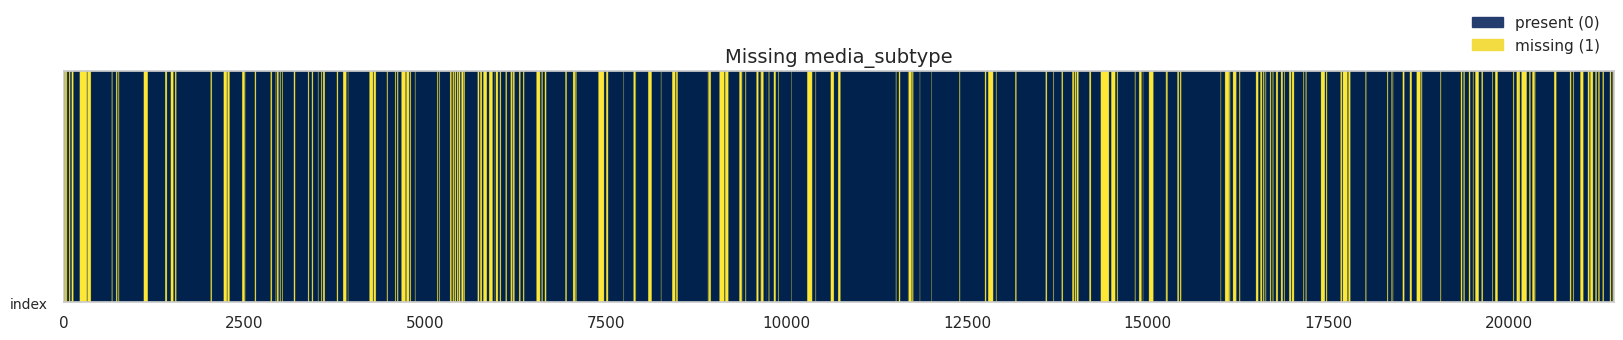

In [7]:
fig, ax = plt.subplots(figsize=(20, 3))
missing_mask = df["media_subtype"].isna().astype(int)
ax.imshow(missing_mask.values[np.newaxis, :], aspect='auto', cmap='cividis')

ax.grid(False)
ax.yaxis.set_visible(False)
ax.set_title("Missing media_subtype", fontsize=14)
ax.text(-0.01, -0.01, 'index', transform=ax.transAxes,
        ha='right', va='center', fontsize=10)

legend_patches = [
    mpatches.Patch(color=plt.cm.cividis(0.15), label='present (0)'),
    mpatches.Patch(color=plt.cm.cividis(0.95), label='missing (1)')
]
ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1, 1.3), ncol=1, frameon=False)

plt.show()

### <a id='toc1_2_5_'></a>[Duplicates](#toc0_)

**Duplicate rows**

In [8]:
dupe_count = df.duplicated().sum()
dupe_count, df[df.duplicated()].head()

(0,
 Empty DataFrame
 Columns: [year, nb_loans, title, author, publisher, classification, library, spine_label, audience, media_subtype, media_type]
 Index: [])

 No **duplicate rows** found.
 
 *Tip:* for cleaning, use `df.drop_duplicates()` (after verifying duplicates represent true duplicates).

**Duplicates analysis (column-wise)**

In [9]:
def duplicate_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame listing columns ranked by percentage of duplicated values.

    Output columns:
      - col_name: original column name
      - duplicates_count: total number of duplicated entries (N - number_of_unique_values)
      - duplicate_percentage: duplicates_count / N * 100 (rounded to 3 decimals)
      - distinct_duplicated_values: number of distinct values that appear more than once
    """
    N: int = len(df)
    rows: List[tuple] = []
    for c in df.columns:
        # count unique values including NaN
        unique = df[c].nunique(dropna=False)
        dup_count = max(0, N - unique)
        dup_pct = (dup_count / N) * 100 if N > 0 else 0.0

        # count distinct values that occur more than once
        counts = df[c].value_counts(dropna=False)
        unique_dup_values = int((counts > 1).sum())

        rows.append((c, dup_count, round(dup_pct, 3), unique_dup_values))

    result = pd.DataFrame(
        rows,
        columns=['col_name', 'duplicates_count', 'duplicate_percentage', 'distinct_duplicated_values']
    )
    return result.sort_values('duplicate_percentage', ascending=False).reset_index(drop=True)
duplicate_summary(df)

,col_name,duplicates_count,duplicate_percentage,distinct_duplicated_values
0,audience,21443,99.986,3
1,media_type,21443,99.986,3
2,library,21437,99.958,7
3,year,21431,99.930,15
4,media_subtype,21426,99.907,17
5,nb_loans,20687,96.461,481
6,publisher,18835,87.825,1784
7,classification,17379,81.036,2601
8,author,17351,80.906,2346
9,spine_label,15371,71.673,3501


### <a id='toc1_2_6_'></a>[Drop orphaned features](#toc0_)

Some rows are missing important features (year..). Drop them safely.

In [10]:
def drop_rows_with_na_in_selected(df: pd.DataFrame, columns: Optional[Iterable[str]] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Drop rows that have NA in selected columns and return (clean_df, dropped_rows).
    - If columns is None, selects all columns that contain any missing values.
    - columns can be a list/iterable of column names to check.
    - Does not modify the original df.
    """
    if columns is None:
        columns_to_check = df.columns[df.isna().any()].tolist()
    else:
        columns_to_check = list(columns)
        missing = set(columns_to_check) - set(df.columns)
        if missing:
            raise KeyError(f"Columns not found in DataFrame: {missing}")

    # identify rows to drop
    mask_has_na = df[columns_to_check].isna().any(axis=1)
    dropped = df[mask_has_na].copy()
    kept = df[~mask_has_na].copy()

    print(f"Columns checked: {columns_to_check}")
    print(f"Total rows: {len(df)}, Dropped: {len(dropped)}, Kept: {len(kept)}")
    if len(dropped) > 0:
        print("Dropped rows by index:")
        print(dropped.index.tolist())

    return kept, dropped
df, dropped_df = drop_rows_with_na_in_selected(df, ['author','year'])

Columns checked: ['author', 'year']
Total rows: 21446, Dropped: 3, Kept: 21443
Dropped rows by index:
[12705, 13017, 14493]


### <a id='toc1_2_7_'></a>[Basic statistics about the loans](#toc0_)

In [11]:
df[['nb_loans']].describe(include='all')

,nb_loans
count,21443.000000
mean,139.069813
std,162.469174
min,12.000000
25%,45.000000
50%,132.000000
75%,182.000000
max,4907.000000


n = 21,446 for the whole period (2011-2024).

*Std dev:* 162.46 --> high variability relative to the mean (coefficient of variation ≈ 1.17).

*Min / Max:* 12 / 4,907 --> extreme maximum indicates **outliers** [intriguing].

*Interquartile range (IQR):* 182 − 45 = 137 --> moderate spread in the middle 50%.

- Right-skewed distribution with a long tail driven by large values (max 4,907).
- Most observations cluster between 12 and ~182; 75% are ≤ 182.

### <a id='toc1_2_8_'></a>[Outliers detection](#toc0_)

**IQR:** the interquartile range is the numeric distance between the 75th percentile (Q3) and the 25th percentile (Q1).

 - Compute Q1 (45) and Q3 (182); IQR = Q3 − Q1 = 137. Define outliers as values < Q1 − 1.5·IQR or > Q3 + 1.5·IQR. For nb_loans that is < 45 − 205.5 (none, since min 12) or > 182 + 205.5 = 387.5. Flag records > 387.5 as outliers for review.

**Z-score:** a standardized value that shows how many standard deviations an observation is from the mean.
 - This detects values that are extreme relative to the transformed, more-normal distribution while avoiding influence from raw-scale heavy tail.

In [12]:
# IQR method for nb_loans
q1, q3 = df['nb_loans'].quantile([0.25,0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers_iqr = df[(df['nb_loans'] < lower) | (df['nb_loans'] > upper)].copy()
print(f"IQR method flagged {len(outliers_iqr)} rows (nb_loans outliers).")
display(outliers_iqr.sort_values('nb_loans', ascending=False).head(5))

# z-score method (robust: log transform to reduce skew)
nz = df[df['nb_loans']>0].copy()
nz['log_loans'] = np.log1p(nz['nb_loans'])
nz['zscore'] = stats.zscore(nz['log_loans'].fillna(0))
z_outliers = nz[np.abs(nz['zscore']) > 3]
print(f"z-score method flagged {len(z_outliers)} rows (|z|>3 on log1p).")
display(z_outliers.sort_values('nb_loans', ascending=False).head(5))

IQR method flagged 540 rows (nb_loans outliers).


,year,nb_loans,title,author,publisher,classification,library,spine_label,audience,media_subtype,media_type
12939,2024,4907,J'aime lire,-,"Paris : Bayard-Presse, 1977",-,CABANIS,P JAIL NO. 492 JAN 2018,E,PERIO,imprimes
9678,2022,4743,Le Journal de Mickey,-,"Paris : Edi-Monde, 1952-",-,CABANIS,"P JOUR NO. 3177 MAI 7, 2013",E,PERIO,imprimes
13026,2022,4307,J'aime lire,-,"Paris : Bayard-Presse, 1977",-,CABANIS,P JAIL NO. 489 OCT 2017,E,PERIO,imprimes
9312,2016,3623,Le Journal de Mickey,-,"Paris : Edi-Monde, 1952-",-,CABANIS,"P JOUR NO. 3095 OCT 12, 2011",E,PERIO,imprimes
7472,2021,3610,Le Journal de Mickey,-,"Paris : Edi-Monde, 1952-",-,CABANIS,"P JOUR NO. 3177 MAI 7, 2013",E,PERIO,imprimes


z-score method flagged 34 rows (|z|>3 on log1p).


,year,nb_loans,title,author,publisher,classification,library,spine_label,audience,media_subtype,media_type,log_loans,zscore
12939,2024,4907,J'aime lire,-,"Paris : Bayard-Presse, 1977",-,CABANIS,P JAIL NO. 492 JAN 2018,E,PERIO,imprimes,8.498622,4.311639
9678,2022,4743,Le Journal de Mickey,-,"Paris : Edi-Monde, 1952-",-,CABANIS,"P JOUR NO. 3177 MAI 7, 2013",E,PERIO,imprimes,8.464636,4.274405
13026,2022,4307,J'aime lire,-,"Paris : Bayard-Presse, 1977",-,CABANIS,P JAIL NO. 489 OCT 2017,E,PERIO,imprimes,8.368229,4.168786
9312,2016,3623,Le Journal de Mickey,-,"Paris : Edi-Monde, 1952-",-,CABANIS,"P JOUR NO. 3095 OCT 12, 2011",E,PERIO,imprimes,8.195334,3.979371
7472,2021,3610,Le Journal de Mickey,-,"Paris : Edi-Monde, 1952-",-,CABANIS,"P JOUR NO. 3177 MAI 7, 2013",E,PERIO,imprimes,8.191740,3.975434


Let's consider the Z-scored *outliers* and see what columns contains the most duplicated informations:

In [13]:
duplicate_summary(z_outliers)

,col_name,duplicates_count,duplicate_percentage,distinct_duplicated_values
0,library,33,97.059,1
1,media_type,33,97.059,1
2,author,32,94.118,2
3,audience,32,94.118,1
4,media_subtype,32,94.118,2
5,classification,29,85.294,3
6,title,26,76.471,5
7,publisher,26,76.471,5
8,year,23,67.647,9
9,spine_label,19,55.882,9


The author column is mostly unrecorded (contains the `-` flag) and the dataset is mostly populated by records from the Toulouse main library (`CABANIS`). The interesting insight is that most of the outliers match the same **media_type**. It corresponds to prints (`imprimes`), media_subtype: `PERIO` (periodical) for the youth audience (`E`).

When a customer borrows a magazine, records are stored at the periodical title level rather than per issue. This creates an inconsistent granularity in the dataset (other items are recorded per-instance). Depending on the analysis, it's important to account for this —e.g., by segmenting data or normalizing records to a common granularity.

### <a id='toc1_2_9_'></a>[Distribution concentration](#toc0_)

Long-tail vs. head concentration (Pareto, Lorenz curve, Gini)

Measure how unevenly something is distributed — i.e., how concentrated the total is among a few items (the "head") versus spread across many items (the "tail"). A high Gini (close to 1) means heavy concentration in a few titles/authors.

Gini (titles): 0.6501
Gini (authors): 0.8012


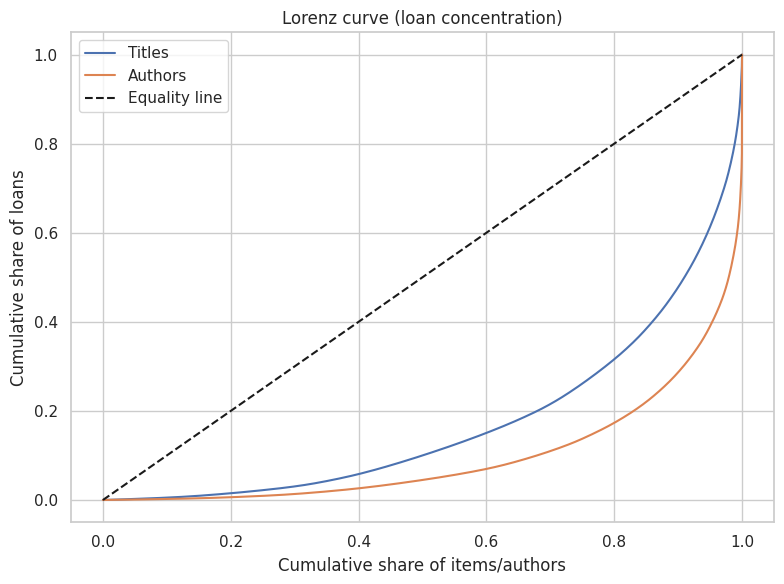

,rank,title,loans,cum_share
0,1,Le Journal de Mickey,32566,0.010921
1,2,J'aime lire,27811,0.020247
2,3,"Mes premiers J'aime lire : lecteurs débutants,...",20293,0.027052
3,4,Les belles histoires,12605,0.031279
4,5,Psychologies magazine,12188,0.035366
5,6,Popi : dès 1 an,11615,0.039261
6,7,Femme actuelle,11091,0.042980
7,8,Astrapi,10493,0.046499
8,9,Youpi : le journal des grands curieux de 3 à 7...,10315,0.049958
9,10,Que choisir,10048,0.053327


In [14]:
# Pareto / Lorenz and Gini for titles and authors (using total loans across all years)
totals_by_title = df.groupby('title', dropna=False)['nb_loans'].sum().sort_values(ascending=False)
totals_by_author = df.groupby('author', dropna=False)['nb_loans'].sum().sort_values(ascending=False)

def lorenz_curve(values):
    vals = np.array(sorted(values))
    cum = np.cumsum(vals)
    total = cum[-1]
    if total==0:
        return np.array([0]), np.array([0])
    lorenz = np.insert(cum/total, 0, 0)
    prop_items = np.linspace(0,1,len(lorenz))
    return prop_items, lorenz

def gini(values):
    # Gini from sorted array
    vals = np.array(values, dtype=float)
    if vals.sum() == 0:
        return 0.0
    vals = np.sort(vals)
    n = len(vals)
    cumvals = np.cumsum(vals)
    g = (2.0 * np.sum((np.arange(1, n+1) * vals)) / (n * vals.sum())) - (n + 1) / n
    return g

p_items_t, lorenz_t = lorenz_curve(totals_by_title.values)
p_items_a, lorenz_a = lorenz_curve(totals_by_author.values)

print("Gini (titles):", round(gini(totals_by_title.values), 4))
print("Gini (authors):", round(gini(totals_by_author.values), 4))

# plot Lorenz curves
plt.figure(figsize=(8,6))
plt.plot(p_items_t, lorenz_t, label='Titles')
plt.plot(p_items_a, lorenz_a, label='Authors')
plt.plot([0,1],[0,1], color='k', linestyle='--', label='Equality line')
plt.xlabel('Cumulative share of items/authors')
plt.ylabel('Cumulative share of loans')
plt.title('Lorenz curve (loan concentration)')
plt.legend()
plt.tight_layout()
plt.show()

# Pareto: cumulative share by ranked items (top N percent)
cum = totals_by_title.cumsum() / totals_by_title.sum()
pct_top_1 = (cum <= 0.01).sum()  # example check
# display top contributors
display(pd.DataFrame({
    'rank': np.arange(1,21),
    'title': totals_by_title.index[:20],
    'loans': totals_by_title.values[:20],
    'cum_share': totals_by_title.cumsum().values[:20] / totals_by_title.sum()
}))

*Info:* A Lorenz curve shows the cumulative share of a variable (y-axis) held by the bottom x% of the population (x-axis); the farther the curve lies below the 45° line, the greater the inequality.

## <a id='toc1_3_'></a>[Section 2 — Column-by-column deep dives](#toc0_)

### <a id='toc1_3_1_'></a>[Years](#toc0_)

In [15]:
year_counts = df.groupby('year', dropna=False)['nb_loans'].sum().sort_index()
year_counts.reset_index().rename(columns={'nb_loans':'total_loans'})

,year,total_loans
0,2011,184034
1,2012,224809
2,2013,190057
3,2014,232196
4,2015,264680
5,2016,282626
6,2017,229906
7,2018,239012
8,2019,210236
9,2020,147292


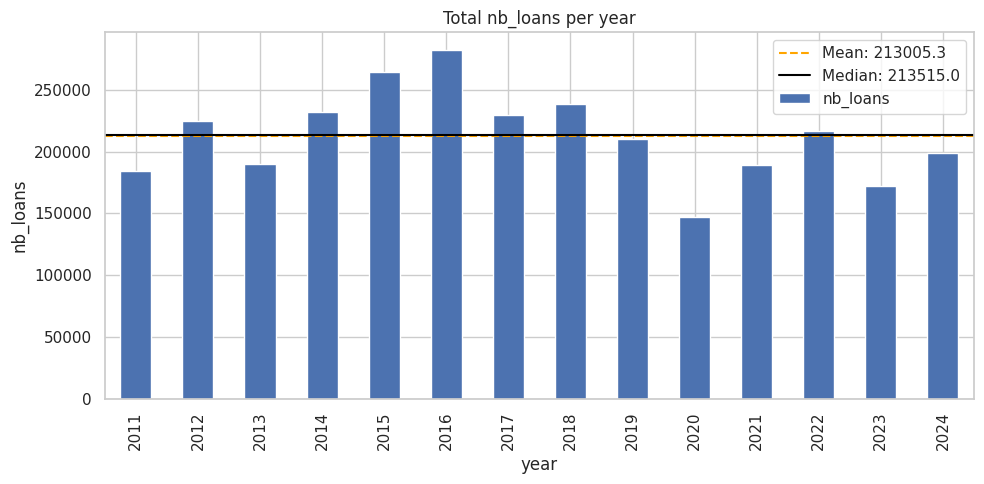

In [16]:
fig, ax = plt.subplots()
year_counts.plot(kind='bar', ax=ax)
mean_val = year_counts.mean()
median_val = year_counts.median()

ax.axhline(mean_val, color='orange', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.1f}')
ax.axhline(median_val, color='black', linestyle='-', linewidth=1.5, label=f'Median: {median_val:.1f}')

ax.set_title("Total nb_loans per year")
ax.set_ylabel("nb_loans")
ax.set_xlabel("year")
ax.legend()
plt.tight_layout()
plt.show()

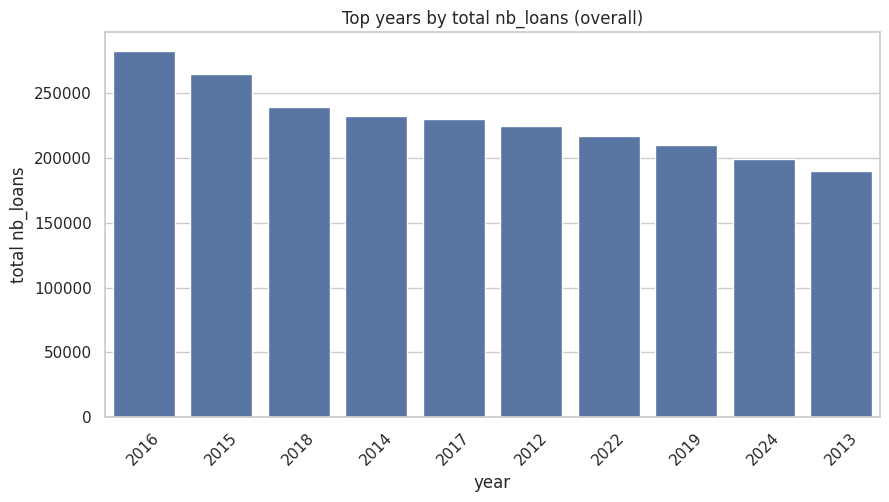

In [17]:
year_totals = df.groupby('year', dropna=False)['nb_loans'].sum().sort_values(ascending=False)
top_years = year_totals.head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_years.index.astype(str), y=top_years.values)
plt.title("Top years by total nb_loans (overall)")
plt.xlabel("year")
plt.ylabel("total nb_loans")
plt.xticks(rotation=45)
plt.show()

### <a id='toc1_3_2_'></a>[nb_loans](#toc0_)

Top 10 highest-loan rows.

In [18]:
# summary of top extremes
df.nlargest(10, 'nb_loans')[['year','title','author','nb_loans']]

,year,title,author,nb_loans
12939,2024,J'aime lire,-,4907
9678,2022,Le Journal de Mickey,-,4743
13026,2022,J'aime lire,-,4307
9312,2016,Le Journal de Mickey,-,3623
7472,2021,Le Journal de Mickey,-,3610
8491,2021,J'aime lire,-,3589
12877,2022,"Mes premiers J'aime lire : lecteurs débutants,...",-,3397
13545,2023,J'aime lire,-,3375
12200,2018,Le Journal de Mickey,-,3333
7413,2020,Le Journal de Mickey,-,3265


Like stated above, in [Outliers detection](#toc1_2_8_), the extreme loan values (youth magazines) are introducing a bias in the dataset. Using a log-scaled y-axis helps to better visualize the distribution of loan counts.

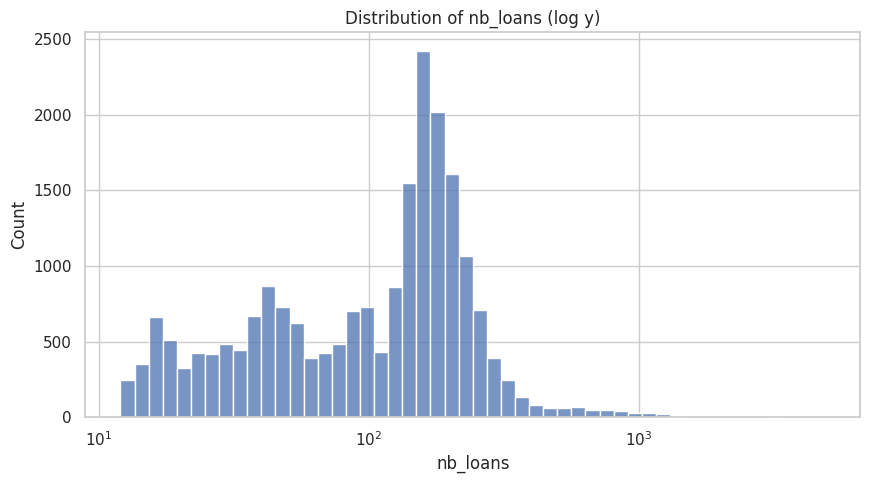

In [19]:
sns.histplot(df['nb_loans'], bins=50, log_scale=(True, False))
plt.title("Distribution of nb_loans (log y)")
plt.xlabel("nb_loans")
plt.show()

### <a id='toc1_3_3_'></a>[Title](#toc0_)

Most **frequent** titles: the frequency is by **row occurrences** (not aggregated loan counts). 

Popularity (aggregation by nb_loans) will be analyzed [section 3](#section-3--by-categories-summaries).

In [20]:
top_title = df.groupby(['title', 'author']).size().reset_index(name='count')
top_title_sorted = top_title.sort_values('count', ascending=False)
print("Unique titles:", top_title_sorted.shape[0])
top_title_sorted.head(10)

Unique titles: 9695


,title,author,count
6059,Là-haut,"Docter, Pete",14
2972,Harry Potter et l'ordre du Phénix,"Yates, David",14
1426,Charlie et la chocolaterie,"Burton, Tim",14
2387,Enfantillages,Aldebert,14
7641,Ratatouille,"Bird, Brad",14
4609,Le Journal de Mickey,-,14
5672,Les plus belles berçeuses du monde : du Mali.....,-,14
6493,"Moi, moche et méchant","Coffin, Pierre",14
607,Astérix & Obélix : mission Cléopâtre,"Chabat, Alain",14
7392,Ponyo sur la falaise,"Miyazaki, Hayao",14


Same titles can match works from different authors (e.g. Alice au pays des merveilles) — it's accurate to group titles by author.

### <a id='toc1_3_4_'></a>[Author](#toc0_)

Top authors, both by row count (frequency) and by aggregated loans (popularity).

In [21]:
print("Unique authors:", df['author'].nunique())
top_by_rows = df[df['author'] != '']['author'].replace('-', pd.NA).dropna().value_counts().head(10)

top_by_loans = (
    df.groupby('author', dropna=False)['nb_loans'].sum()
      .drop(index='-', errors='ignore')
      .sort_values(ascending=False)
      .head(10)
)
print("\nMost occuring authors:\n", top_by_rows, "\n\nMost popular authors:\n", top_by_loans)

Unique authors: 4094

Most occuring authors:
 author
Saint-Mars, Dominique de       293
Sobral, Patrick                228
Lyfoung, Patricia              184
Midam                          135
Sobral, Patrick (1972-....)    122
Konami, Kanata                 122
Miyazaki, Hayao                117
Pink Floyd                     106
Nob                            104
Dutto, Olivier                  99
Name: count, dtype: Int64 

Most popular authors:
 author
Saint-Mars, Dominique de       49409
Sobral, Patrick                48875
Lyfoung, Patricia              32680
Sobral, Patrick (1972-....)    27893
Miyazaki, Hayao                25144
Midam                          23805
Konami, Kanata                 22479
Mr Tan                         20573
Cazenove, Christophe           20548
Nob                            19570
Name: nb_loans, dtype: int32


**Caution:** Author variants can fragment counts (e.g. "Sobral, Patrick (1972-....)" v. "Sobral, Patrick")

>**TODO:** Implement an effective normalization method (lowercase/trimming combined to NLP based methods?).

### <a id='toc1_3_5_'></a>[media_type and media_subtype](#toc0_)

Shows which media types/subtypes dominate.

In [22]:
print(df['media_type'].value_counts(dropna=False))
print()
print(df['media_subtype'].value_counts(dropna=False).head(20))

media_type
cds         7494
films       7055
imprimes    6894
Name: count, dtype: Int64

media_subtype
DVDFIC      5529
CD          5505
<NA>        4243
BD          2512
PERIO       1344
ROM         1183
POL          450
LIVCD        255
ALB          210
LIVDOC       141
TE            27
METLAN        11
SF             9
DVDDOC         8
LIV            5
CONTE          4
ZMICROS        4
CDVDROM        1
LIVCDVDR       1
LV             1
Name: count, dtype: Int64


Explanations on media subtypes are available [here](https://www.kaggle.com/datasets/grimespoint/toulouse-public-library-mdiathque-dataset).

### <a id='toc1_3_6_'></a>[Audience](#toc0_)

In [23]:
df['audience'].value_counts(dropna=False)

audience
A     12593
E      8480
BB      370
Name: count, dtype: Int64

The adult (`A`) category prevails by a large margin. `BB` (under 5 y.o.) audience is marginal.

### <a id='toc1_3_7_'></a>[Remaining columns (publisher, classification, library, spine_label)](#toc0_)

Surface frequent values.

In [24]:
for c in ['publisher','classification','library','spine_label']:
    if c in df.columns:
        print(f"\n--- {c} top values ---\n")
        print(df[c].value_counts().head(5))


--- publisher top values ---

publisher
-                                                  6561
[S.l] : Buena Vista Home Intertainment, 2006         93
Marne-la-Vallée : The Walt Disney Company, 2012      84
Grenoble : Glénat, 2011                              81
Marne-la-Vallée : The Walt Disney Company, 2014      76
Name: count, dtype: Int64

--- classification top values ---

classification
S099.2    1119
-         1080
S220       509
S291       369
E SAI      274
Name: count, dtype: Int64

--- library top values ---

library
CABANIS    21130
EMP          154
CYP           78
COL           48
MGM           14
Name: count, dtype: Int64

--- spine_label top values ---

spine_label
E SAI         267
2 PIN 40      105
AB 780.2 C     98
2 BEA 20       49
LEVY           44
Name: count, dtype: Int64


## <a id='toc1_4_'></a>[Section 3 — Summaries by category](#toc0_)

### <a id='toc1_4_1_'></a>[Plot years with most loan counts per audience](#toc0_)

For each audience, display top years.

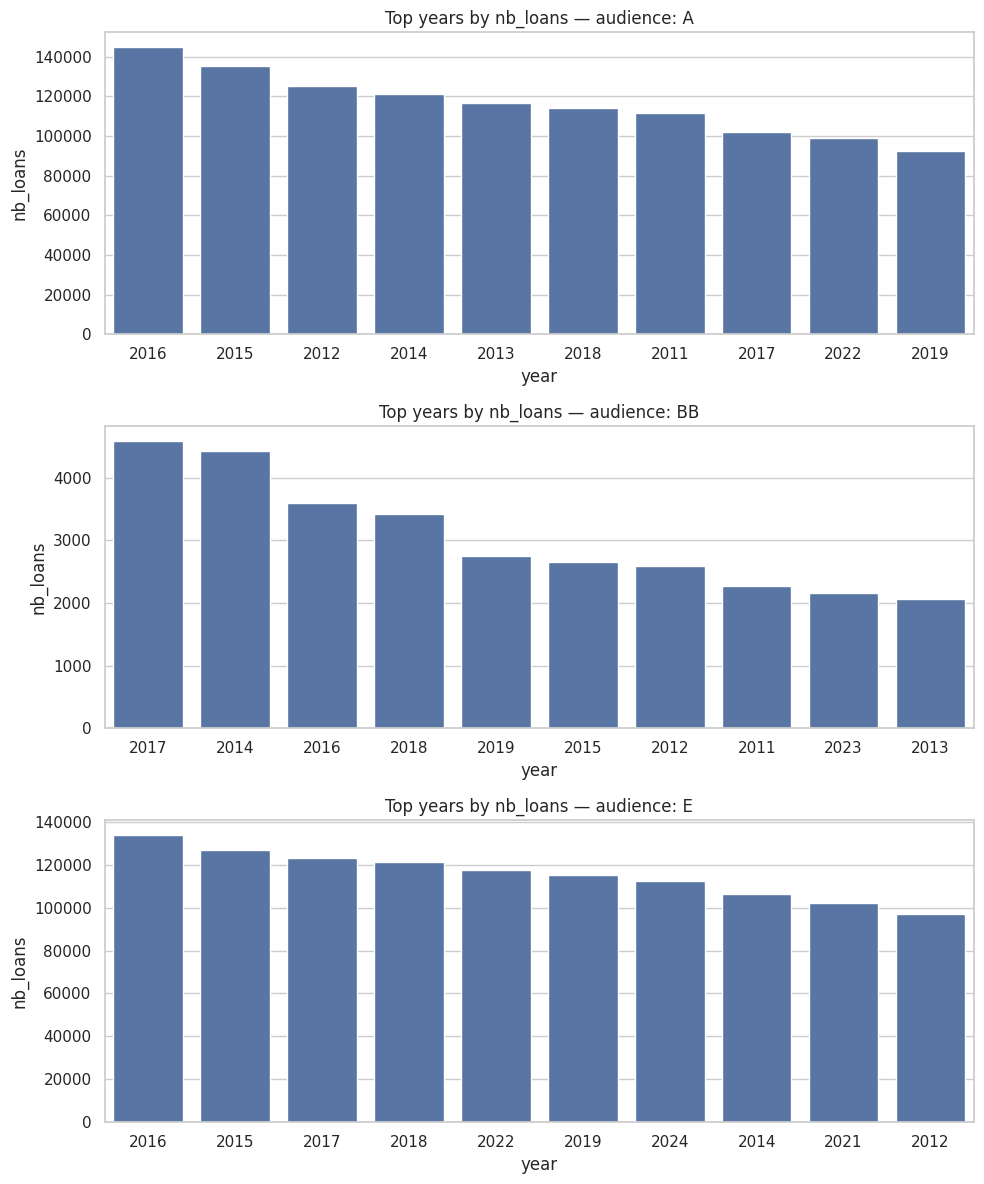

In [25]:
audiences = df['audience'].dropna().unique()
fig, axes = plt.subplots(nrows=min(3,len(audiences)), ncols=1, figsize=(10,4*min(3,len(audiences))))
if len(audiences)==1:
    axes = [axes]
for ax, aud in zip(axes, sorted(audiences)):
    s = df[df['audience']==aud].groupby('year')['nb_loans'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=s.index.astype(str), y=s.values, ax=ax)
    ax.set_title(f"Top years by nb_loans — audience: {aud}")
    ax.set_xlabel("year"); ax.set_ylabel("nb_loans")
plt.tight_layout()
plt.show()

### <a id='toc1_4_2_'></a>[Plot years with most loan counts per media_type](#toc0_)

Shows top years for up to 3 media types.

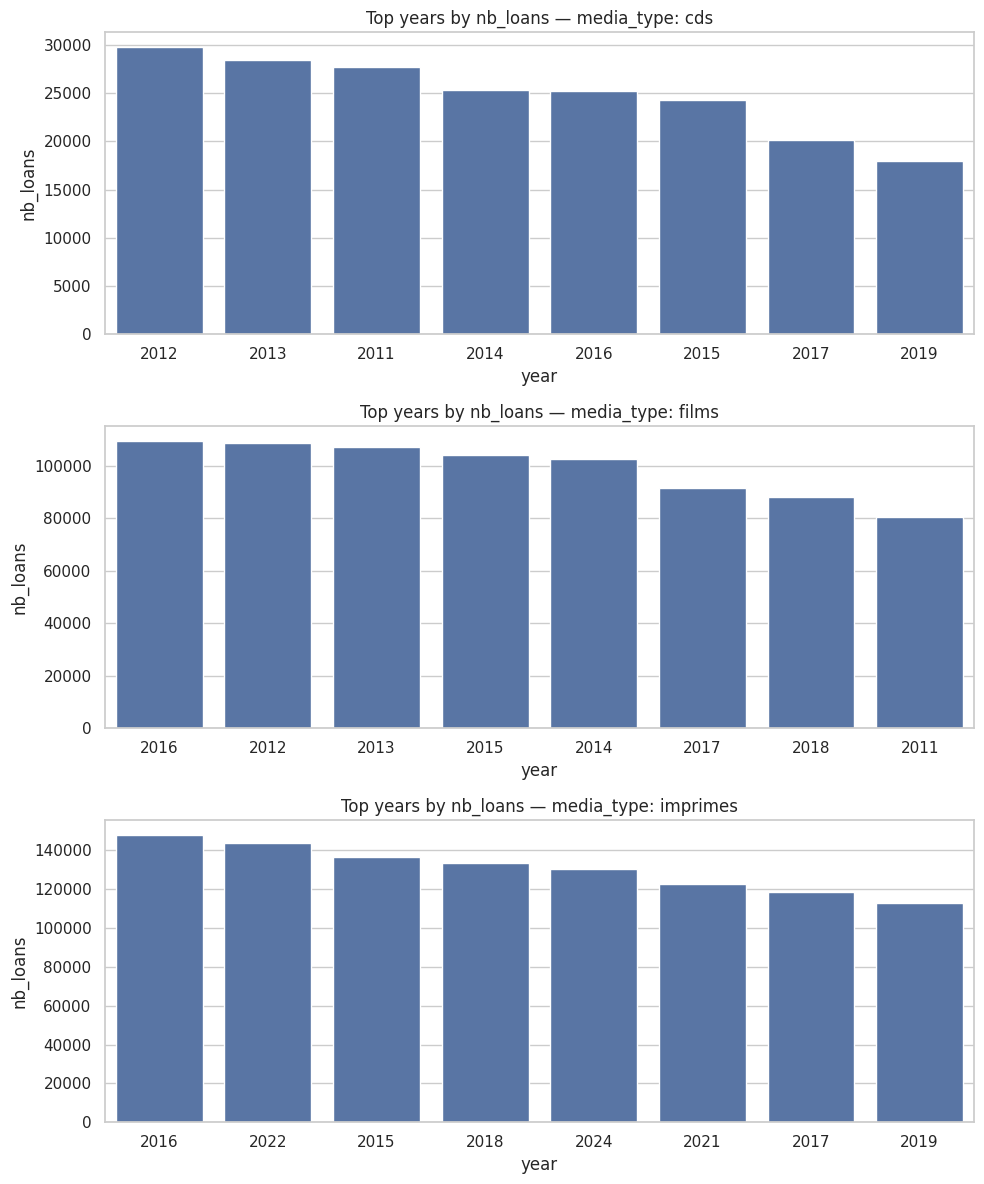

In [26]:
media_types = df['media_type'].dropna().unique()
n = min(3, len(media_types))
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10,4*n))
for ax, mt in zip(axes, sorted(media_types)[:n]):
    s = df[df['media_type']==mt].groupby('year')['nb_loans'].sum().sort_values(ascending=False).head(8)
    sns.barplot(x=s.index.astype(str), y=s.values, ax=ax)
    ax.set_title(f"Top years by nb_loans — media_type: {mt}")
    ax.set_xlabel("year"); ax.set_ylabel("nb_loans")
plt.tight_layout()
plt.show()

### <a id='toc1_4_3_'></a>[Most popular authors — overall, per audience, per media_type (plots)](#toc0_)

Plots and tables showing most popular authors. Normalizing author names to merge variants will improve results.

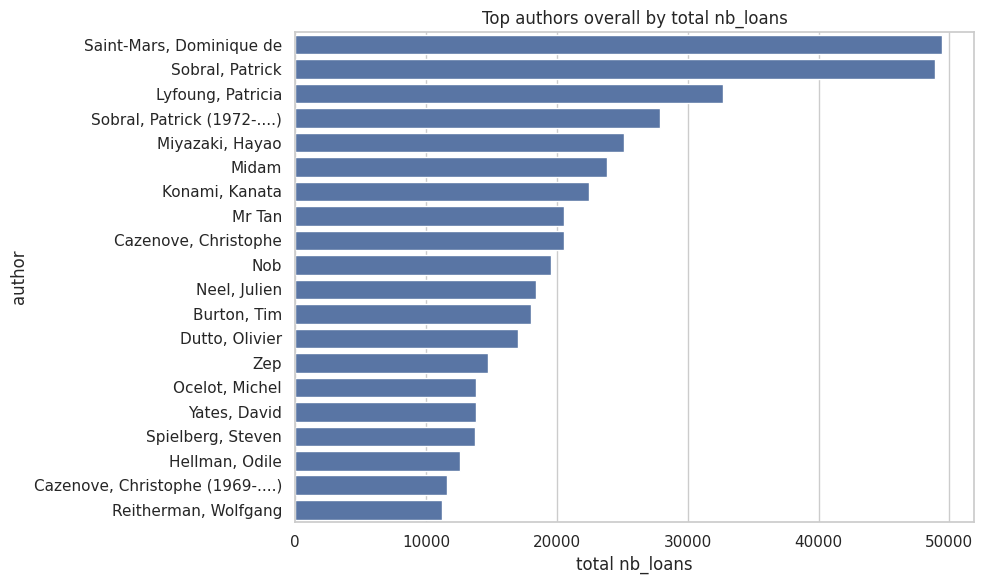

In [27]:
clean_authors = df['author'].replace('-', pd.NA)
top_authors_overall = (
    df.assign(author=clean_authors)
      .dropna(subset=['author'])
      .groupby('author')['nb_loans']
      .sum()
      .sort_values(ascending=False)
      .head(20)
)

plt.figure(figsize=(10,6))
sns.barplot(y=top_authors_overall.index.astype(str), x=top_authors_overall.values)
plt.title("Top authors overall by total nb_loans")
plt.xlabel("total nb_loans"); plt.ylabel("author")
plt.tight_layout()
plt.show()

In [28]:
mt_list = sorted(df['media_type'].dropna().unique())
for mt in mt_list:
    s = df[df['media_type']==mt].assign(author=clean_authors).dropna(subset=['author']).groupby('author')['nb_loans'].sum().sort_values(ascending=False).head(10)
    print(f"--- media_type: {mt} ---")
    display(s)

--- media_type: cds ---


author
Pink Floyd               4662
Aldebert                 3077
Bohy, Hélène             2504
Muse                     2085
Bashung, Alain           1889
Hudrisier, Cécile        1719
Daft Punk                1700
Radiohead                1684
Maalouf, Ibrahim. Trp    1679
Beatles                  1638
Name: nb_loans, dtype: int32

--- media_type: films ---


author
Miyazaki, Hayao         24965
Burton, Tim             18005
Ocelot, Michel          13848
Yates, David            13796
Spielberg, Steven       13766
Reitherman, Wolfgang    11236
Allen, Woody            10536
Columbus, Chris         10278
Saldanha, Carlos         8095
Szabo, Thomas            8055
Name: nb_loans, dtype: int32

--- media_type: imprimes ---


author
Saint-Mars, Dominique de       49409
Sobral, Patrick                48875
Lyfoung, Patricia              32680
Sobral, Patrick (1972-....)    27893
Midam                          23805
Konami, Kanata                 22479
Mr Tan                         20573
Cazenove, Christophe           20548
Nob                            19570
Neel, Julien                   17083
Name: nb_loans, dtype: int32

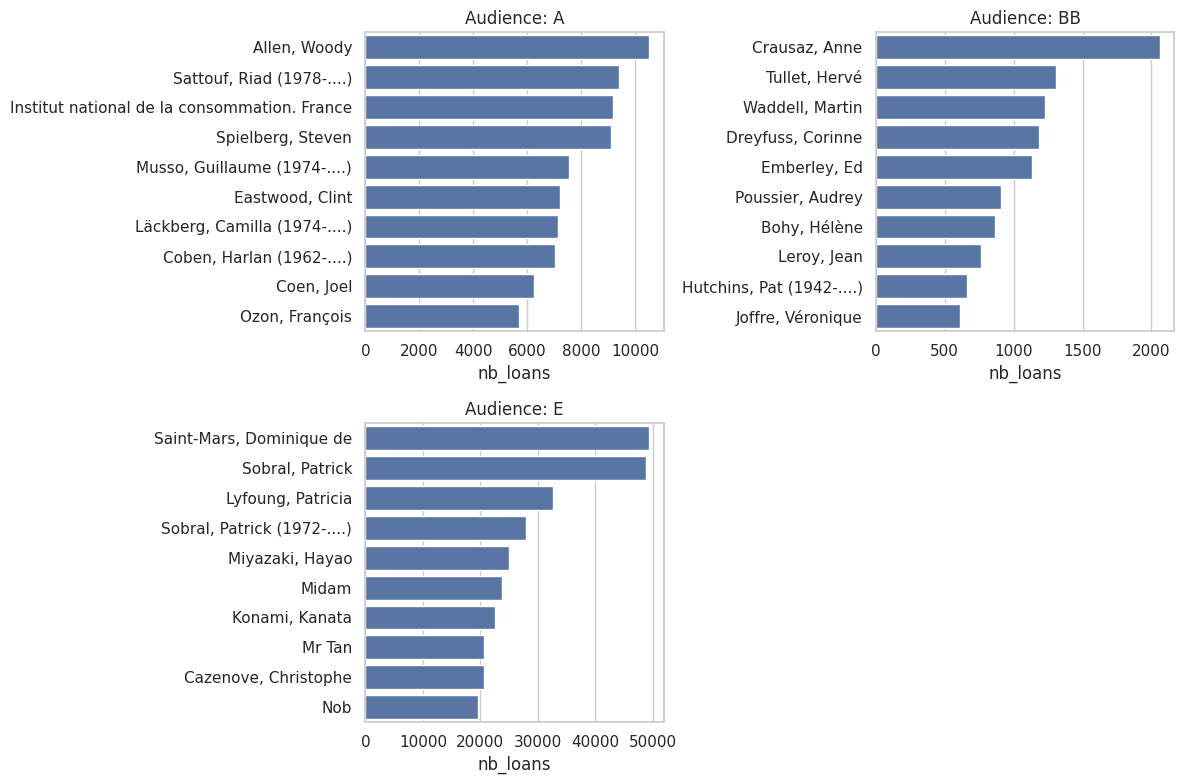

In [29]:
Aude_list = sorted(df['audience'].dropna().unique())
ncols = 2
nrows = (len(Aude_list)+1)//ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4*nrows))
axes = axes.flatten()
for ax, Aude in zip(axes, Aude_list):
    clean = (
        df[df['audience'] == Aude]
        .assign(author=lambda d: d['author'].replace('-', pd.NA))
        .dropna(subset=['author'])
    )
    s = (
        clean.groupby('author')['nb_loans']
            .sum()
            .sort_values(ascending=False)
            .head(10)
    )

    sns.barplot(x=s.values, y=s.index.astype(str), ax=ax)
    ax.set_title(f"Audience: {Aude}"); ax.set_xlabel("nb_loans"); ax.set_ylabel("")
for ax in axes[len(Aude_list):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

Cross-tab: audience × media_type patterns:

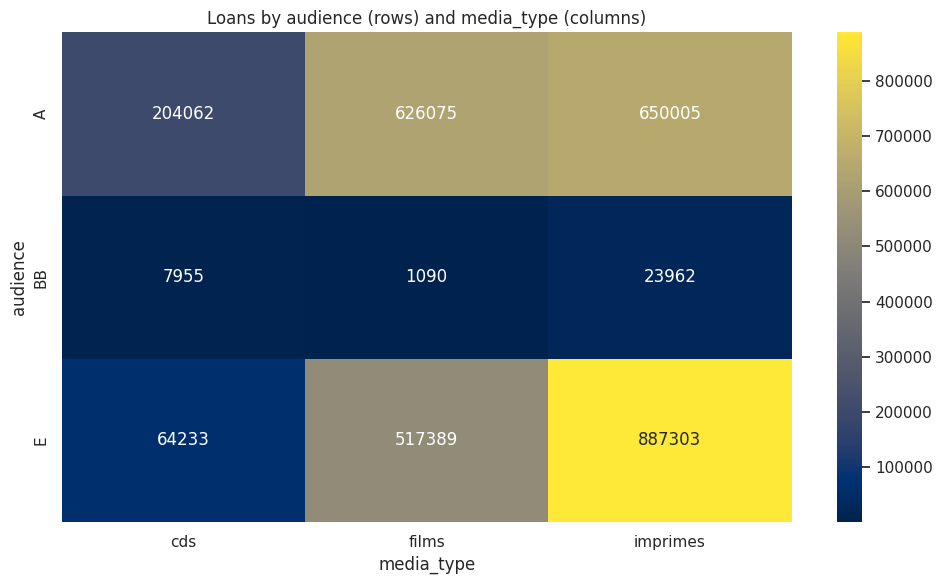

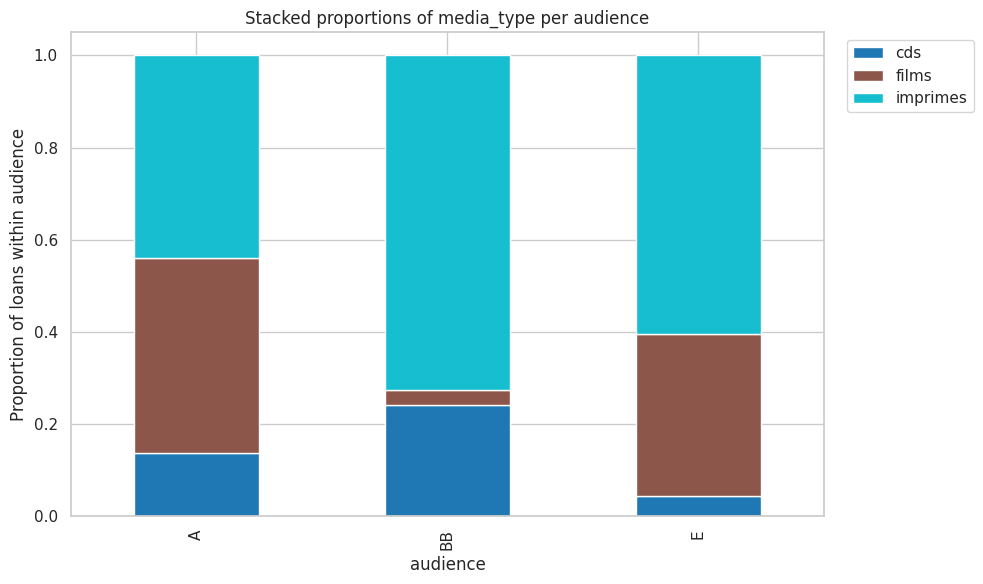

In [30]:
pivot = df.pivot_table(index='audience', columns='media_type', values='nb_loans', aggfunc='sum', fill_value=0)
pivot_sorted = pivot.loc[sorted(pivot.index.astype(str))]  # consistent order

# raw heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot_sorted, annot=True, fmt='.0f', cmap='cividis')
plt.title("Loans by audience (rows) and media_type (columns)")
plt.tight_layout()
plt.show()

# normalized by audience row totals (proportions)
pivot_prop = pivot_sorted.div(pivot_sorted.sum(axis=1), axis=0).fillna(0)

# stacked bar chart (audience share per media_type)
pivot_prop.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab10')
plt.ylabel('Proportion of loans within audience')
plt.legend(bbox_to_anchor=(1.02,1))
plt.title('Stacked proportions of media_type per audience')
plt.tight_layout()
plt.show()

### <a id='toc1_4_4_'></a>[Trends](#toc0_)

Yearwise totals per title and author, year-over-year delta and pct-change. Caution: a value of zero does not represent the actual loan number; it indicates that the item is no longer in the top 500 (a "shooting star").

- For more similar insights: check this [repository](https://github.com/brooks-code/toulouse-biblio-chronicle).

Years compared: 2023 -> 2024

Top title gainers (abs change):


year,abs_change,pct_change,2023,2024
title,,,,
Le Journal de Mickey,2095.0,2.596035,807.0,2902.0
J'aime lire,1532.0,0.453926,3375.0,4907.0
Astrapi,833.0,2.509036,332.0,1165.0
"Mes premiers J'aime lire : lecteurs débutants, grande section maternelle, CP et CE1",814.0,0.359065,2267.0,3081.0
Les belles histoires,764.0,0.645270,1184.0,1948.0
Julie : vive les filles : de 8 à 12 ans,697.0,1.729529,403.0,1100.0
Cuisine actuelle,548.0,1.607038,341.0,889.0
Spirou,542.0,1.731629,313.0,855.0
Psychologies magazine,534.0,1.816327,294.0,828.0


Top title losers (abs change):


year,abs_change,pct_change,2023,2024
title,,,,
Vivre vite / Brigitte Giraud,-327.0,-1.0,327.0,0.0
On était des loups / Sandrine Collette,-249.0,-1.0,249.0,0.0
Les sources / Marie-Hélène Lafon,-247.0,-1.0,247.0,0.0
Les ténèbres et la nuit / Michael Connelly ; traduit de l'anglais (Etats-Unis) par Robert Pépin,-237.0,-1.0,237.0,0.0
Le livre des soeurs / Amélie Nothomb,-233.0,-1.0,233.0,0.0
La grande ourse / Maylis Adhémar,-223.0,-1.0,223.0,0.0
Crépuscule / Philippe Claudel,-222.0,-1.0,222.0,0.0
La ritournelle / Aurélie Valognes,-220.0,-1.0,220.0,0.0
Cinabre : thriller / Nicolas Druart,-220.0,-1.0,220.0,0.0


Top author gainers (abs change):


year,abs_change,pct_change,2023,2024
author,,,,
Nob,1063.0,0.334382,3179.0,4242.0
"Cazenove, Christophe",962.0,0.360165,2671.0,3633.0
"Hellman, Odile",764.0,0.645270,1184.0,1948.0
"Didier, Anne",675.0,0.463599,1456.0,2131.0
Mr Tan,624.0,0.129568,4816.0,5440.0
Institut national de la consommation. France,514.0,1.636943,314.0,828.0
"Lyfoung, Patricia",497.0,0.120397,4128.0,4625.0
"Alwett, Audrey",452.0,0.509009,888.0,1340.0
"Sobral, Patrick",416.0,0.047510,8756.0,9172.0


Top author losers (abs change):


year,abs_change,pct_change,2023,2024
author,,,,
Lylian,-918.0,-1.000000,918.0,0.0
"Lemaitre, Pierre (1951-....)",-586.0,-0.588945,995.0,409.0
Midam,-559.0,-0.181141,3086.0,2527.0
"Girard, Charlotte",-485.0,-1.000000,485.0,0.0
"Sattouf, Riad (1978-....)",-387.0,-0.254941,1518.0,1131.0
"Valognes, Aurélie (1983-....)",-375.0,-1.000000,375.0,0.0
"Norek, Olivier (1975-....)",-375.0,-0.684307,548.0,173.0
"Siegel, Mark",-367.0,-0.408686,898.0,531.0
"Lupano, Wilfrid (1971-....)",-352.0,-1.000000,352.0,0.0


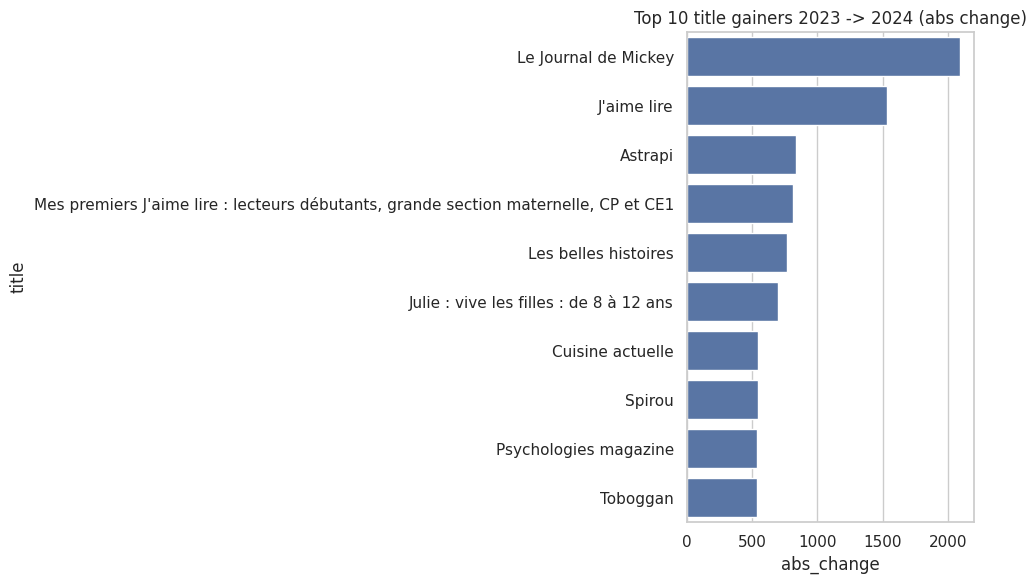

In [31]:
agg_title = df.groupby(['title','year'], dropna=False)['nb_loans'].sum().reset_index()
agg_author = df.assign(author=clean_authors).dropna(subset=['author']).groupby(['author','year'], dropna=False)['nb_loans'].sum().reset_index()

# pivot to wide form (rows=title/author, cols=year)
title_pivot = agg_title.pivot(index='title', columns='year', values='nb_loans').fillna(0)
author_pivot = agg_author.pivot(index='author', columns='year', values='nb_loans').fillna(0)

# compute yoy absolute and percent change for the last two years available
years_sorted = sorted(df['year'].dropna().unique())
if len(years_sorted) < 2:
    raise RuntimeError("Need at least two years of data for YoY change.")
y_latest, y_prev = years_sorted[-1], years_sorted[-2]

title_pivot['abs_change'] = title_pivot[y_latest] - title_pivot[y_prev]
title_pivot['pct_change'] = np.where(title_pivot[y_prev]==0,
                                     np.where(title_pivot[y_latest]>0, np.inf, 0),
                                     title_pivot['abs_change'] / title_pivot[y_prev])

author_pivot['abs_change'] = author_pivot[y_latest] - author_pivot[y_prev]
author_pivot['pct_change'] = np.where(author_pivot[y_prev]==0,
                                      np.where(author_pivot[y_latest]>0, np.inf, 0),
                                      author_pivot['abs_change'] / author_pivot[y_prev])

# Top gainers and losers (absolute)
top_title_gainers = title_pivot.sort_values('abs_change', ascending=False).head(20)
top_title_losers  = title_pivot.sort_values('abs_change', ascending=True).head(20)

top_author_gainers = author_pivot.sort_values('abs_change', ascending=False).head(20)
top_author_losers  = author_pivot.sort_values('abs_change', ascending=True).head(20)

# display tables
print(f"Years compared: {y_prev} -> {y_latest}\n")
print("Top title gainers (abs change):")
display(top_title_gainers[['abs_change','pct_change', y_prev, y_latest]].head(10))

print("Top title losers (abs change):")
display(top_title_losers[['abs_change','pct_change', y_prev, y_latest]].head(10))

print("Top author gainers (abs change):")
display(top_author_gainers[['abs_change','pct_change', y_prev, y_latest]].head(10))

print("Top author losers (abs change):")
display(top_author_losers[['abs_change','pct_change', y_prev, y_latest]].head(10))

# bar: top 10 title gainers by abs_change
plt.figure(figsize=(10,6))
sns.barplot(x='abs_change', y=top_title_gainers.head(10).index, data=top_title_gainers.head(10))
plt.title(f"Top 10 title gainers {y_prev} -> {y_latest} (abs change)")
plt.xlabel("abs_change")
plt.tight_layout()
plt.show()

Growth or decline study: a YoY pct change heatmap for top 50 authors :

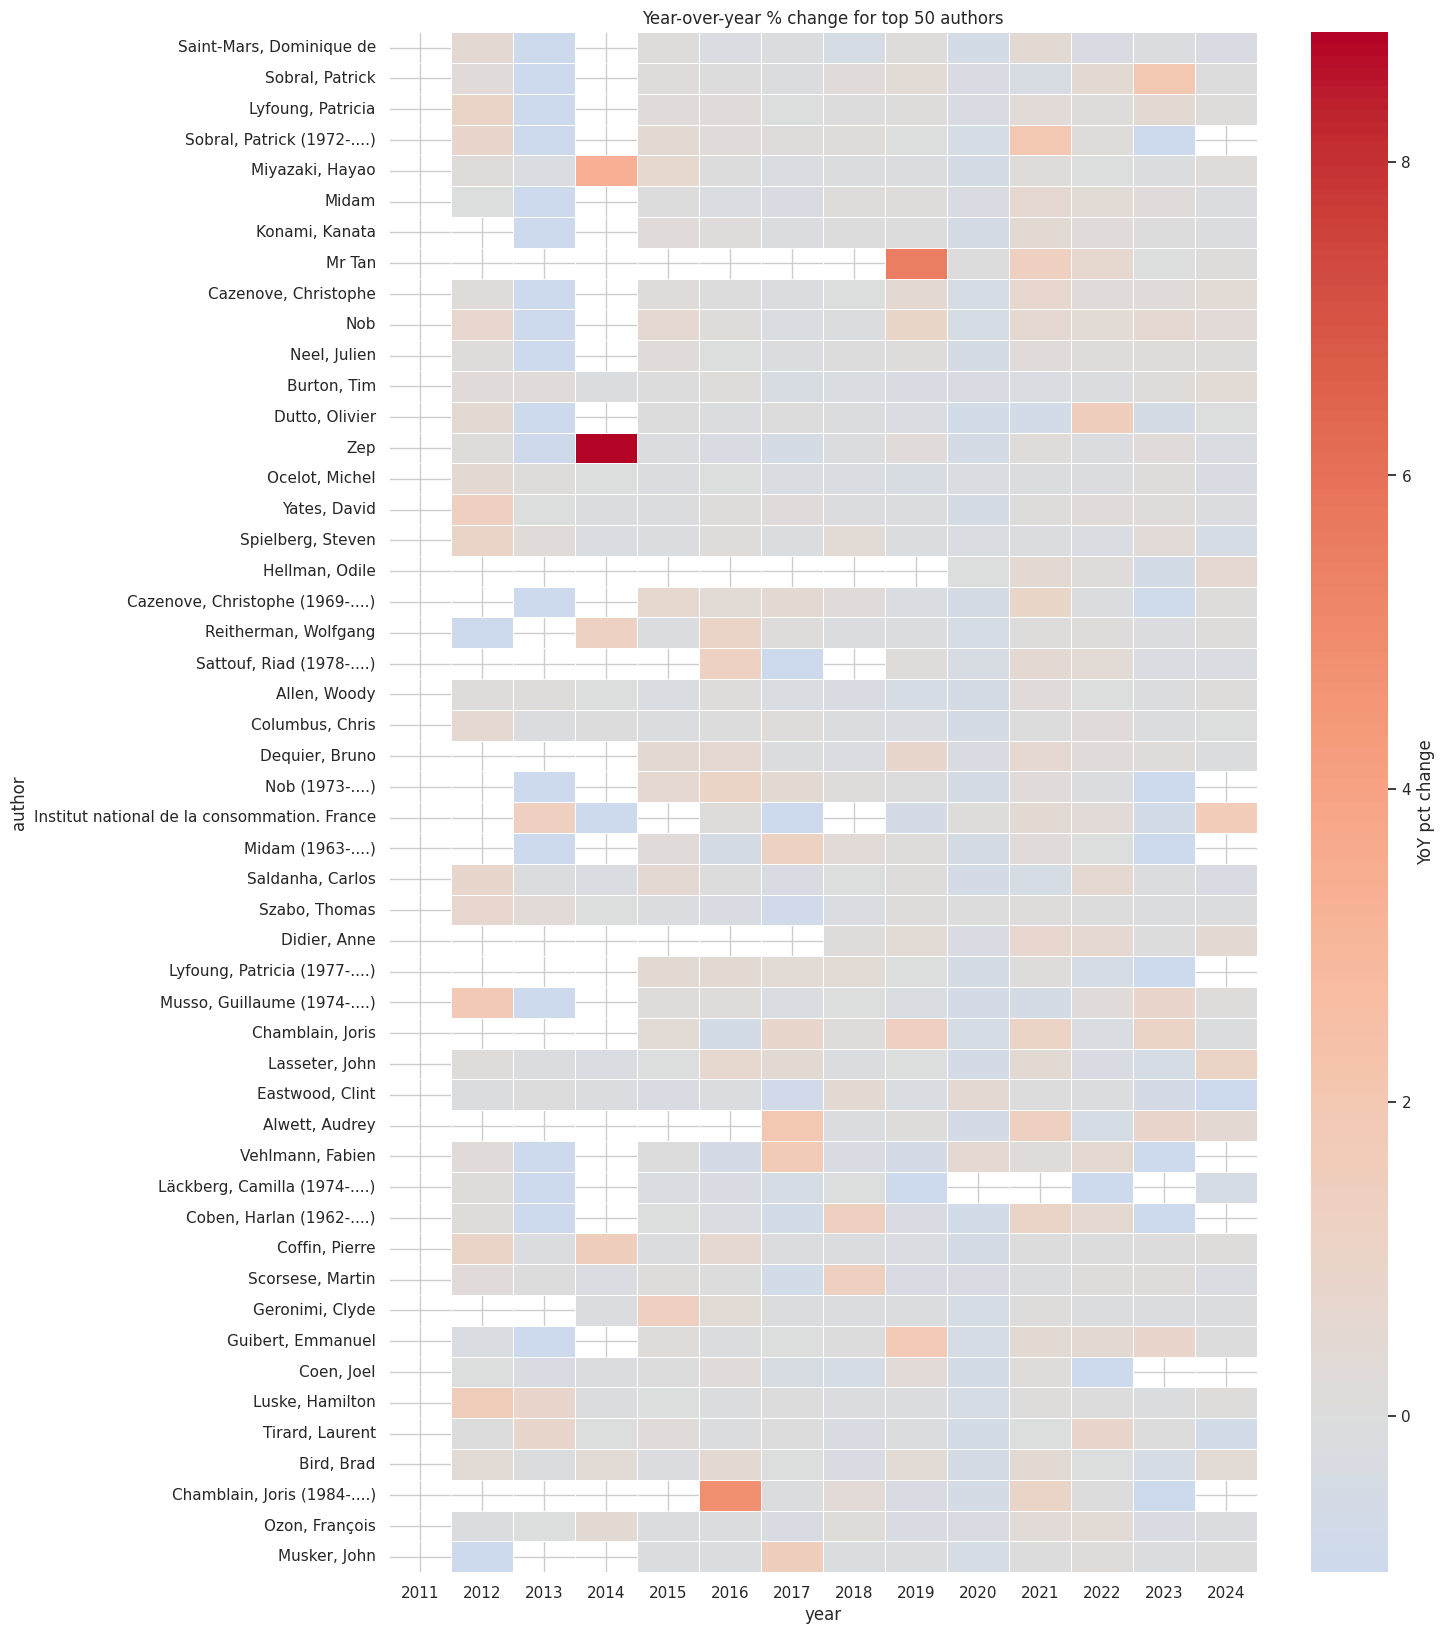

In [34]:
authors_total = df.assign(author=clean_authors).dropna(subset=['author']).groupby('author', dropna=False)['nb_loans'].sum().sort_values(ascending=False)
top50_authors = authors_total.head(50).index.tolist()

author_year = df[df['author'].isin(top50_authors)].groupby(['author','year'])['nb_loans'].sum().unstack(fill_value=0)
# compute pct-change along years axis
author_pct = author_year.pct_change(axis=1).replace([np.inf, -np.inf], np.nan)

# order years and authors
years = sorted(author_pct.columns)
author_pct = author_pct.loc[top50_authors, years]  # ensure consistent order

plt.figure(figsize=(14,20))
sns.heatmap(author_pct, cmap='coolwarm', center=0, cbar_kws={'label':'YoY pct change'}, linewidths=.5)
#vlag
plt.title('Year-over-year % change for top 50 authors')
plt.xlabel('year')
plt.ylabel('author')
#plt.tight_layout()
plt.show()

## <a id='toc1_5_'></a>[Section 4 — Jupyter interactive widget](#toc0_)

Select a year to show top 3 authors and top 3 titles, overall, per audience and per media_type.

In [33]:
years = sorted(df['year'].dropna().unique())
years = ['Overall'] + list(years)   # add overall option first

def top_k_by_filters(year, k=3):
    if year == 'Overall':
        sel = df.copy()  # use entire dataset
    else:
        sel = df[df['year'] == year]

    # overall authors and titles
    overall_authors = sel.assign(author=clean_authors).dropna(subset=['author']).groupby('author')['nb_loans'].sum().sort_values(ascending=False).head(k)
    overall_titles  = sel.assign(author=clean_authors).dropna(subset=['author']).groupby('title')['nb_loans'].sum().sort_values(ascending=False).head(k)
    # per audience
    auds = {}
    for aud in sorted(sel['audience'].dropna().unique()):
        s_auth = sel[sel['audience'] == aud].assign(author=clean_authors).dropna(subset=['author']).groupby('author')['nb_loans'].sum().sort_values(ascending=False).head(k)
        s_title = sel[sel['audience'] == aud].assign(author=clean_authors).dropna(subset=['author']).groupby('title')['nb_loans'].sum().sort_values(ascending=False).head(k)
        auds[aud] = {'authors': s_auth, 'titles': s_title}
    # per media_type
    mts = {}
    for mt in sorted(sel['media_type'].dropna().unique()):
        s_auth = sel[sel['media_type'] == mt].assign(author=clean_authors).dropna(subset=['author']).groupby('author')['nb_loans'].sum().sort_values(ascending=False).head(k)
        s_title = sel[sel['media_type'] == mt].assign(author=clean_authors).dropna(subset=['author']).groupby('title')['nb_loans'].sum().sort_values(ascending=False).head(k)
        mts[mt] = {'authors': s_auth, 'titles': s_title}
    return overall_authors, overall_titles, auds, mts

out = widgets.Output()
dropdown = widgets.Dropdown(options=years, description='Year:', value=years[0])  # default to 'Overall'

def on_change(change):
    if change['name'] == 'value':
        year = change['new']
        overall_authors, overall_titles, auds, mts = top_k_by_filters(year, k=3)
        with out:
            out.clear_output()
            print(f"Year: {year}\n")
            print("Overall - Top 3 authors:")
            display(overall_authors)
            print("Overall - Top 3 titles:")
            display(overall_titles)
            print("\nPer audience:")
            for aud, v in auds.items():
                print(f"Audience {aud} - authors:")
                display(v['authors'])
                print(f"Audience {aud} - titles:")
                display(v['titles'])
            print("\nPer media_type:")
            for mt, v in mts.items():
                print(f"Media type {mt} - authors:")
                display(v['authors'])
                print(f"Media type {mt} - titles:")
                display(v['titles'])

dropdown.observe(on_change)
display(dropdown, out)

# initialize
on_change({'name':'value','new':dropdown.value})

Dropdown(description='Year:', options=('Overall', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, …

Output()

Curious about how the library loans dataset was created? Check this [notebook](https://github.com/brooks-code/toulouse-biblio-chronicle)!

Brainmade with passion during a windy october 2024 day in France by [brk](github.com/brooks-code) ❤